# NIHCXR Clinical Drift Experiments Tutorial

## Import Libraries and Load NIHCXR Dataset

In [1]:
from functools import partial

from monai.transforms import AddChanneld, Compose, Lambdad, Resized, ToDeviced
from torchxrayvision.models import DenseNet

from cyclops.data.loader import load_nihcxr
from cyclops.data.slicer import SliceSpec
from cyclops.data.utils import apply_transforms
from cyclops.monitor import ClinicalShiftApplicator, Detector, Reductor, TSTester
from cyclops.monitor.plotter import plot_drift_experiment, plot_drift_timeseries
from cyclops.monitor.utils import get_device

device = get_device()

nih_ds = load_nihcxr("/mnt/data/clinical_datasets/NIHCXR")

/home/amritk/.cache/pypoetry/virtualenvs/pycyclops-Svpk0lXb-py3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example 1. Generate Source/Target Dataset for Experiments (1-2)

In [2]:
shifter = ClinicalShiftApplicator(
    "sex", source=None, target="F", shift_id="Patient Gender"
)
source_ds, target_ds = shifter.apply_shift(nih_ds, num_proc=6)

transforms = Compose(
    [
        AddChanneld(keys=("features",), allow_missing_keys=True),
        Resized(
            keys=("features",), spatial_size=(1, 224, 224), allow_missing_keys=True
        ),
        Lambdad(
            keys=("features",),
            func=lambda x: ((2 * (x / 255.0)) - 1.0) * 1024,
            allow_missing_keys=True,
        ),
        ToDeviced(keys=("features",), device=device, allow_missing_keys=True),
    ]
)

source_ds = source_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)
target_ds = target_ds.with_transform(
    partial(apply_transforms, transforms=transforms),
    columns=["features"],
    output_all_columns=True,
)

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 72215.44 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 98348.34 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118408.04 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 131253.99 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 137686.67 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 143753.24 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 75298.06 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 107897.91 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 118322.37 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 138348.74 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 143764.27 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:00<00:00, 148635.38 examples/s]

## Example 2. Sensitivity test experiment with 3 dimensionality reduction techniques


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.60 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 27.83 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 37.46 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.82 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 49.10 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.20 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.14 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.85 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.42 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.77 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.46 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.40 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.88 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.44 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.50 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 47.46 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.44 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 49.76 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 16.88 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.51 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:02, 36.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 42.54 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 46.20 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 48.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 48.30 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.85 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.00 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:04, 16.63 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 27.88 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.34 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:02<00:10, 15.66 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:05, 26.95 examples/s]

Map:  48%|████▊     | 96/200 [00:03<00:03, 33.79 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 39.34 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 43.48 examples/s]

Map:  96%|█████████▌| 192/200 [00:05<00:00, 45.71 examples/s]

Map: 100%|██████████| 200/200 [00:05<00:00, 45.38 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.65 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.86 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.54 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.43 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.36 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.25 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.91 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.29 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.55 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.80 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.03 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.10 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.33 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.74 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 43.73 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.23 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 50.09 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.17 examples/s]

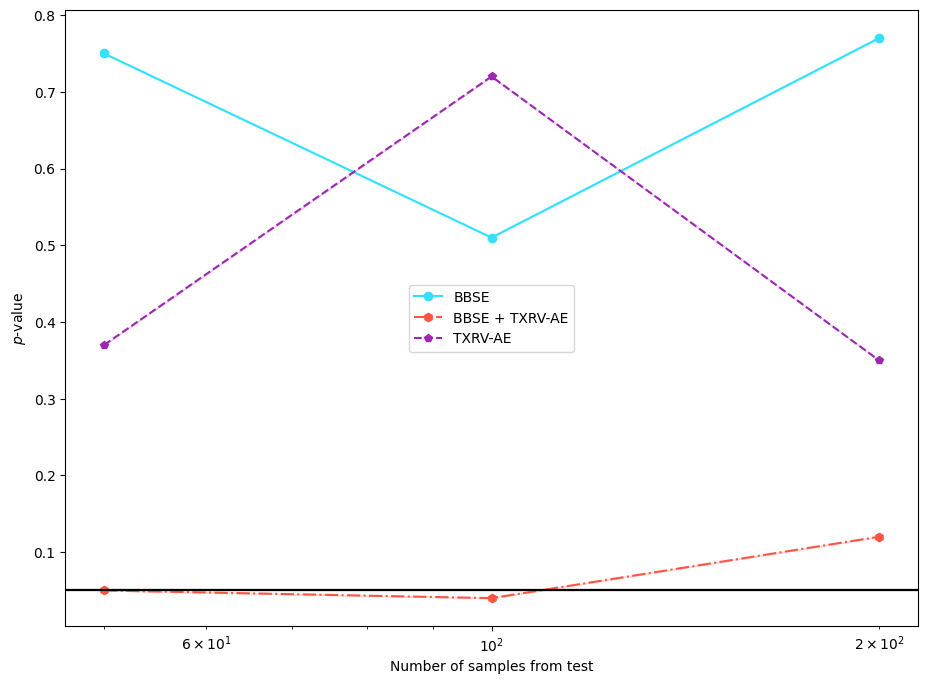

In [3]:
model = DenseNet(weights="densenet121-res224-all")
dr_methods = {
    "BBSE": "bbse-soft",
    "BBSE + TXRV-AE": "bbse-soft+txrv-ae",
    "TXRV-AE": "txrv-ae",
}
results = {}

for name, dr_method in dr_methods.items():
    if name == "TXRV-AE":
        reductor = Reductor(dr_method=dr_method, device=device)
    else:
        reductor = Reductor(dr_method=dr_method, model=model, device=device)
    detector = Detector(
        "sensitivity_test",
        reductor=reductor,
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    result = detector.detect_shift(source_ds, target_ds)
    results[name] = result
plot_drift_experiment(results)

## Example 3. Sensitivity test experiment with models trained on different datasets

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:10, 16.52 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 28.94 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 37.96 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.25 examples/s]

Map:  80%|████████  | 160/200 [00:04<00:00, 48.49 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 53.01 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.71 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.97 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.95 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.53 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.21 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.15 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.95 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.63 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.48 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.57 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.93 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.08 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 50.94 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.37 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 32.02 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.03 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.83 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.86 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.55 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.48 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.90 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.96 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.71 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.60 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.08 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.63 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 44.30 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 48.92 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.12 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.12 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.58 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.28 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.24 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.85 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.84 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.42 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.68 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.06 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.86 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.05 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.88 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.16 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.81 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.89 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.72 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.12 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.02 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.85 examples/s]

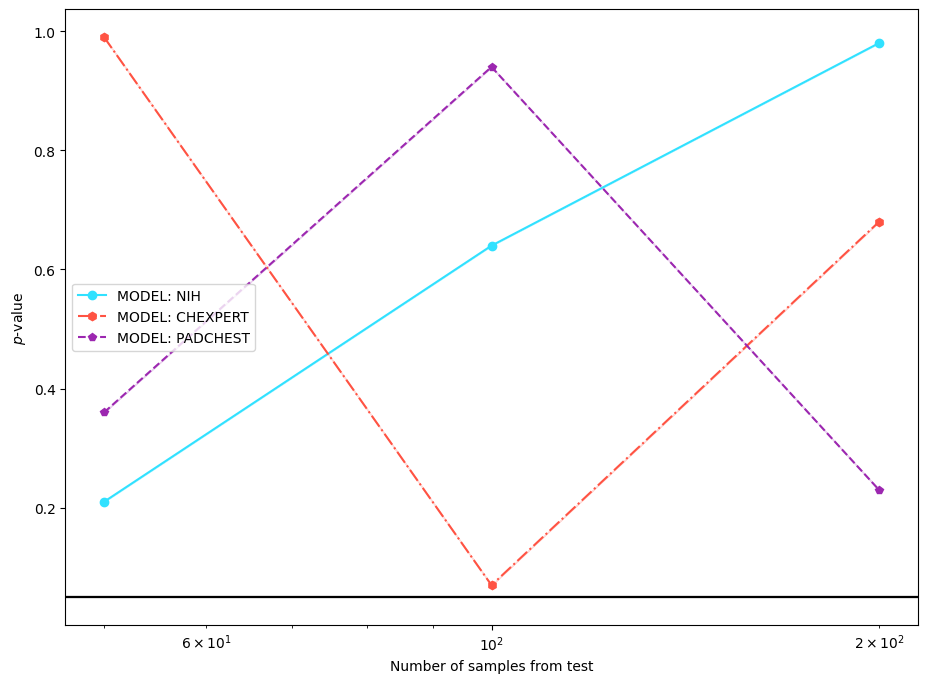

In [4]:
models = {
    "MODEL: NIH": "densenet121-res224-nih",
    "MODEL: CHEXPERT": "densenet121-res224-chex",
    "MODEL: PADCHEST": "densenet121-res224-pc",
}
results = {}

for model_name, model in models.items():
    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(
            dr_method="bbse-soft", model=DenseNet(weights=model), device=device
        ),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[model_name] = detector.detect_shift(source_ds, target_ds)
plot_drift_experiment(results)

## Example 4. Sensitivity test experiment with different clinical shifts

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52761.26 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75910.70 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86728.14 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 92181.62 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 94765.60 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 100752.13 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 57193.64 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 82703.90 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 96960.44 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104977.40 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 110101.14 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 116781.83 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.33 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.01 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.73 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.05 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.83 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.80 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.81 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 18.13 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.87 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.43 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.63 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.45 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.09 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.00 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.87 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.59 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52012.51 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72996.36 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87229.88 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 95899.50 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 111278.72 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 123033.07 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52601.28 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72898.95 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 86932.68 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 97153.86 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103831.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108840.17 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.46 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.80 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.56 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.37 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.80 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.56 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.85 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.82 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.66 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.71 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.19 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 38.73 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.18 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.00 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.03 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.05 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.53 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.68 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.34 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52258.18 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75749.53 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 90091.11 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98055.00 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 103331.16 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 108255.05 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51528.05 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 73725.53 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 83894.76 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 98847.72 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 107402.94 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111862.78 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.23 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.54 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.08 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.20 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.68 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.61 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.12 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.70 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.32 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.86 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 30.40 examples/s]

Map:  96%|█████████▌| 96/100 [00:02<00:00, 39.33 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.93 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 30.75 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 39.40 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.71 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 49.83 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 51.81 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 51.36 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 52393.72 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:00, 75032.27 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 87502.69 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 104005.05 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:00<00:00, 108388.75 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 111752.37 examples/s]

Filter (num_proc=6):   0%|          | 0/112120 [00:00<?, ? examples/s]

Filter (num_proc=6):  17%|█▋        | 18687/112120 [00:00<00:01, 51126.33 examples/s]

Filter (num_proc=6):  33%|███▎      | 37374/112120 [00:00<00:01, 72891.10 examples/s]

Filter (num_proc=6):  50%|█████     | 56061/112120 [00:00<00:00, 89700.78 examples/s]

Filter (num_proc=6):  67%|██████▋   | 74748/112120 [00:00<00:00, 99082.74 examples/s]

Filter (num_proc=6):  83%|████████▎ | 93434/112120 [00:01<00:00, 102906.70 examples/s]

Filter (num_proc=6): 100%|██████████| 112120/112120 [00:01<00:00, 107766.66 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.06 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.62 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 41.21 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 48.04 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 53.25 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 56.69 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 56.18 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.50 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.35 examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:  32%|███▏      | 32/100 [00:01<00:03, 17.37 examples/s]

Map:  64%|██████▍   | 64/100 [00:02<00:01, 29.98 examples/s]

Map:  96%|█████████▌| 96/100 [00:03<00:00, 35.74 examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 17.83 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 29.99 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 38.94 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 45.65 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 50.47 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 52.79 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 52.49 examples/s]

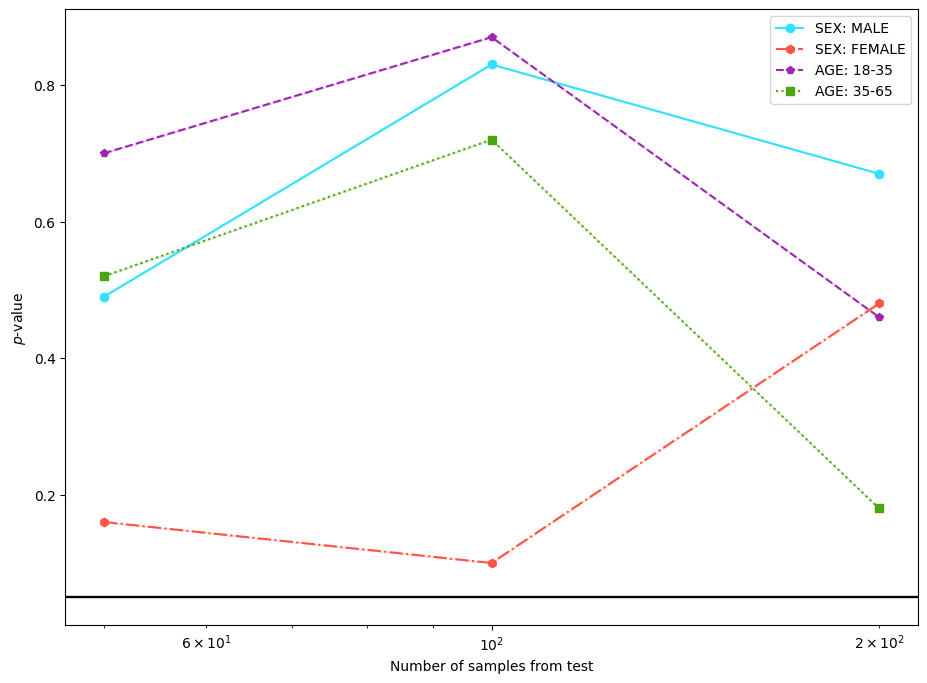

In [5]:
model = DenseNet(weights="densenet121-res224-all")
source_slice = None
target_slices = {
    "SEX: MALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "M"}}]),
    "SEX: FEMALE": SliceSpec(spec_list=[{"Patient Gender": {"value": "F"}}]),
    "AGE: 18-35": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 18, "max_value": 35}}]
    ),
    "AGE: 35-65": SliceSpec(
        spec_list=[{"Patient Age": {"min_value": 35, "max_value": 65}}]
    ),
}
results = {}

for name, target_slice in target_slices.items():
    source_slice = None
    shifter = ClinicalShiftApplicator(
        "custom", source=source_slice, target=target_slice
    )
    ds_source, ds_target = shifter.apply_shift(nih_ds, num_proc=6)

    ds_source = ds_source.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )
    ds_target = ds_target.with_transform(
        partial(apply_transforms, transforms=transforms),
        columns=["features"],
        output_all_columns=True,
    )

    detector = Detector(
        "sensitivity_test",
        reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
        tester=TSTester(tester_method="mmd"),
        source_sample_size=200,
        target_sample_size=[50, 100, 200],
        num_runs=1,
    )
    results[name] = detector.detect_shift(ds_source, ds_target)
plot_drift_experiment(results)

## Example 5. Rolling window experiment with synthetic timestamps using biweekly window

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:  16%|█▌        | 32/200 [00:01<00:09, 18.17 examples/s]

Map:  32%|███▏      | 64/200 [00:02<00:04, 31.76 examples/s]

Map:  48%|████▊     | 96/200 [00:02<00:02, 40.70 examples/s]

Map:  64%|██████▍   | 128/200 [00:03<00:01, 47.62 examples/s]

Map:  80%|████████  | 160/200 [00:03<00:00, 52.86 examples/s]

Map:  96%|█████████▌| 192/200 [00:04<00:00, 55.83 examples/s]

Map: 100%|██████████| 200/200 [00:04<00:00, 55.24 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.94 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.52 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.43 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.23 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.84 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.12 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.63 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.34 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.99 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.83 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.54 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.71 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.36 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.40 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.90 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.25 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.04 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.92 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.80 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.15 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 23.82 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.49 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.41 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.02 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.96 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.88 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.78 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.57 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.45 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.69 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.01 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.10 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.75 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.93 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.97 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.73 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.73 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.76 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 25.53 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.00 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.10 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.08 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 17.99 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.01 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:01, 16.72 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 24.76 examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:  64%|██████▍   | 32/50 [00:01<00:00, 18.05 examples/s]

Map: 100%|██████████| 50/50 [00:02<00:00, 26.18 examples/s]

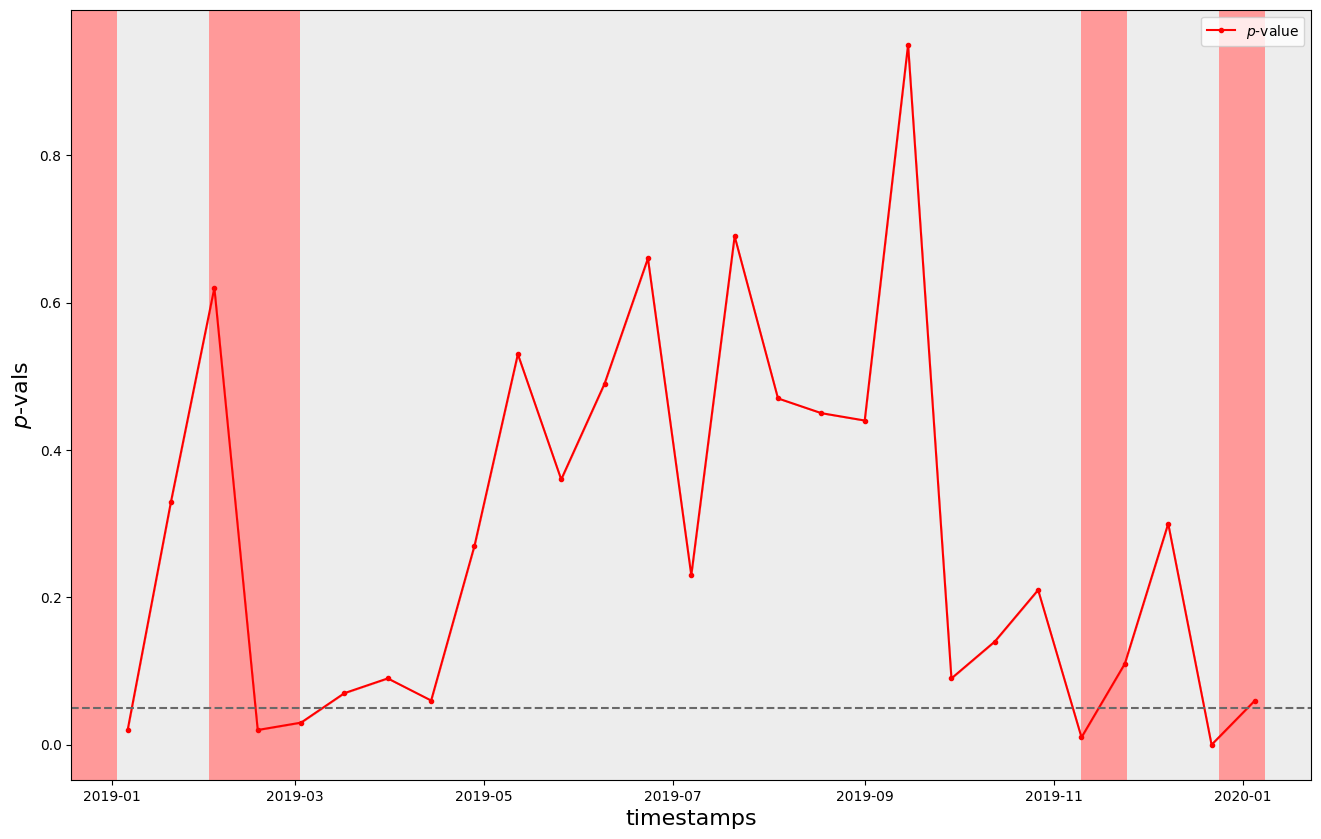

In [6]:
model = DenseNet(weights="densenet121-res224-all")
detector = Detector(
    "rolling_window_drift",
    reductor=Reductor(dr_method="bbse-soft", model=model, device=device),
    tester=TSTester(tester_method="mmd"),
    source_sample_size=200,
    target_sample_size=50,
    timestamp_column="timestamp",
    window_size="2W",
)

results = detector.detect_shift(source_ds, target_ds)
plot_drift_timeseries(results)